# Metodos en python para extracción de datos

Codigo en python el cual realiza la conexion a base de datos y exporta en formato excel los datos historicos de despacho mediante la función obtener_despachos, ademas mediante la función obtener_eventos_rastreo_gps podemos traer la data de un vehiculo en especifico con su detalle operativo


In [2]:
pip install mysql-connector-python==8.0.33

# IMPORTACIÓN DE PAQUETES

In [1]:
import pandas as pd
import mysql.connector
from mysql.connector import Error
import os
import csv
import numpy as np
import matplotlib.pyplot as plt

# CONEXIÓN A LA BASE DE DATOS

In [3]:

# Función para conectar a la base de datos
def conectar_bd(database):
    try:
        conexion = mysql.connector.connect(
            host=os.getenv("DB_HOST", "147.93.47.161"),
            user=os.getenv("DB_USER", "masterbus"),
            password=os.getenv("DB_PASSWORD", "9@#$%&yhif"),
            database=database
        )
        if conexion.is_connected():
            print(f"✅ Conexión a la base de datos {database} establecida.")
            return conexion
    except Error as e:
        print(f"❌ Error al conectar a MySQL ({database}): {e}")
        return None

# Función para obtener el esquema de la base de datos
def obtener_esquema(conexion):
    if not conexion:
        print("❌ No hay conexión a la base de datos.")
        return None
    try:
        cursor = conexion.cursor()
        query = """
            SELECT TABLE_NAME, COLUMN_NAME, DATA_TYPE, COLUMN_TYPE
            FROM INFORMATION_SCHEMA.COLUMNS
            WHERE TABLE_SCHEMA = %s
        """
        cursor.execute(query, (conexion.database,))
        resultado = cursor.fetchall()
        esquema = {}
        for tabla, columna, tipo, columna_tipo in resultado:
            if tabla not in esquema:
                esquema[tabla] = []
            esquema[tabla].append({"columna": columna, "tipo": tipo, "detalle": columna_tipo})
        cursor.close()
        return esquema
    except Error as e:
        print(f"❌ Error al obtener el esquema: {e}")
        return None

# EXTRACCIÓN DE LOS DATOS


In [4]:

def obtener_despachos(conexion, fecha_ini, fecha_fin, archivo_csv="despachos.csv"):
    if not conexion:
        print("❌ No hay conexión a la base de datos.")
        return None

    try:
        cursor = conexion.cursor(dictionary=True)
        query = """
            SELECT FECHA_INICIAL, HORA_INICIAL_PLAN, HORA_INICIAL_REAL, HORA_INICIAL_AUX, FECHA_FINAL,
                   HORA_FINAL_PLAN, HORA_FINAL_REAL, HORA_FINAL_AUX, FK_RUTA, PASAJEROS, DISTANCIA,
                   FK_VEHICULO, FK_CONDUCTOR, ESTADO_DESPACHO, PK_INTERVALO_DESPACHO, PK_INFORMACION_REGISTRADORA
            FROM
            (
                SELECT PK_INTERVALO_DESPACHO, FECHA_INICIAL, HORA_INICIAL AS HORA_INICIAL_PLAN,
                       (SELECT HORA_REAL FROM tbl_planilla_despacho WHERE FK_INTERVALO_DESPACHO = PK_INTERVALO_DESPACHO AND TIPO_PUNTO = 1) AS HORA_INICIAL_REAL,
                       FECHA_FINAL, HORA_FINAL AS HORA_FINAL_PLAN,
                       (SELECT HORA_REAL FROM tbl_planilla_despacho WHERE FK_INTERVALO_DESPACHO = PK_INTERVALO_DESPACHO AND TIPO_PUNTO = 3) AS HORA_FINAL_REAL,
                       (SELECT ESTADO_DESPACHO FROM tbl_planilla_despacho WHERE FK_INTERVALO_DESPACHO = PK_INTERVALO_DESPACHO AND TIPO_PUNTO = 3) AS ESTADO_DESPACHO
                FROM tbl_intervalo_despacho
                WHERE FECHA_INICIAL BETWEEN %s AND %s AND ESTADO = 1
            ) AS ta
            INNER JOIN
            (
                SELECT HORA_SALIDA_BASE_SALIDA AS HORA_INICIAL_AUX, HORA_INGRESO AS HORA_FINAL_AUX, FK_RUTA,
                       DIFERENCIA_NUM AS PASAJEROS, DISTANCIA_METROS AS DISTANCIA, FK_VEHICULO, FK_CONDUCTOR,
                       FK_INTERVALO_DESPACHO, PK_INFORMACION_REGISTRADORA
                FROM tbl_informacion_registradora
                WHERE FECHA_SALIDA_BASE_SALIDA BETWEEN %s AND %s
            ) AS tb
            ON ta.PK_INTERVALO_DESPACHO = tb.FK_INTERVALO_DESPACHO
        """
        cursor.execute(query, (fecha_ini, fecha_fin, fecha_ini, fecha_fin))
        resultados = cursor.fetchall()

        if not resultados:
            print("⚠️ No hay registros de despachos para exportar.")
            return None
        #despacho = pd.DataFrame(resultados)

        # descargar en un csv
        with open(archivo_csv, mode='w', newline='', encoding='utf-8') as file:
            writer = csv.DictWriter(file, fieldnames=resultados[0].keys())
            writer.writeheader()
            writer.writerows(resultados)

        print(f"✅ Datos exportados en '{archivo_csv}'.")
        cursor.close()
        return archivo_csv
    except Error as e:
        print(f"❌ Error al obtener los despachos: {e}")
        return None

# Función para cerrar la conexión a la base de datos
def cerrar_conexion(conexion):
    if conexion and conexion.is_connected():
        conexion.close()
        print("✅ Conexión cerrada correctamente.")


In [5]:
# Extracción de la Información:

if __name__ == "__main__":
    conexion_principal = conectar_bd("bd_montebello_rdw") # consolidados de rutas despachos.csv
    conexion_gps = conectar_bd("bd_montebello_rdw_gps") # Demanda de pasajeros, eventos vehiculos por recorrido

    if conexion_principal and conexion_gps:
        # Obtener esquemas de las bases de datos ---  Solo si es necesario
        esquema_principal = obtener_esquema(conexion_principal)

        fecha_ini = '2024-04-16'
        fecha_fin = '2025-03-25'
        datos = obtener_despachos(conexion_principal, fecha_ini, fecha_fin)


    cerrar_conexion(conexion_principal)

✅ Conexión a la base de datos bd_montebello_rdw establecida.
✅ Conexión a la base de datos bd_montebello_rdw_gps establecida.
✅ Datos exportados en 'despachos.csv'.
✅ Conexión cerrada correctamente.


In [6]:
datos = pd.read_csv("despachos.csv")

In [7]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55952 entries, 0 to 55951
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   FECHA_INICIAL                55952 non-null  object
 1   HORA_INICIAL_PLAN            55952 non-null  object
 2   HORA_INICIAL_REAL            55265 non-null  object
 3   HORA_INICIAL_AUX             55952 non-null  object
 4   FECHA_FINAL                  55952 non-null  object
 5   HORA_FINAL_PLAN              55952 non-null  object
 6   HORA_FINAL_REAL              49744 non-null  object
 7   HORA_FINAL_AUX               55952 non-null  object
 8   FK_RUTA                      55952 non-null  int64 
 9   PASAJEROS                    55952 non-null  int64 
 10  DISTANCIA                    55952 non-null  int64 
 11  FK_VEHICULO                  55952 non-null  int64 
 12  FK_CONDUCTOR                 55952 non-null  int64 
 13  ESTADO_DESPACHO              55

De la información general del conjunto de datos de despachos se puede observar que:

 - Hay un total de 50884 registros realizados, que corresponden al número de despachos entre las fechas del '2024-04-16' al  '2025-03-11'
  - La información relacionada consta de 16 variables que se le miden despacho
  - Hay 8 variables con tipo de dato entero y 8 variables objeto o caracteres.

# CONVERSIÓN DE FORMATO PARA PREVISUALIZAR

In [8]:
# Convertir FECHA_INICIAL y FECHA_FINAL a datetime
datos['FECHA_INICIAL'] = pd.to_datetime(datos['FECHA_INICIAL']).dt.date
datos['FECHA_FINAL'] = pd.to_datetime(datos['FECHA_FINAL']).dt.date

In [9]:
# Convertir las columnas de timedelta64[ns] a horas (o minutos, segundos, etc.)
datos['HORA_INICIAL_PLAN'] = pd.to_timedelta(datos['HORA_INICIAL_PLAN']).dt.components['hours']
datos['HORA_INICIAL_REAL'] = pd.to_timedelta(datos['HORA_INICIAL_REAL']).dt.components['hours']
datos['HORA_INICIAL_AUX'] = pd.to_timedelta(datos['HORA_INICIAL_AUX']).dt.components['hours']
datos['HORA_FINAL_PLAN'] = pd.to_timedelta(datos['HORA_FINAL_PLAN']).dt.components['hours']
datos['HORA_FINAL_REAL'] = pd.to_timedelta(datos['HORA_FINAL_REAL']).dt.components['hours']
datos['HORA_FINAL_AUX'] = pd.to_timedelta(datos['HORA_FINAL_AUX']).dt.components['hours']

# DATOS FALTANTES

In [10]:
# Calcular el porcentaje de datos faltantes
porcentaje_faltantes = (datos.isnull().sum() / len(datos)) * 100

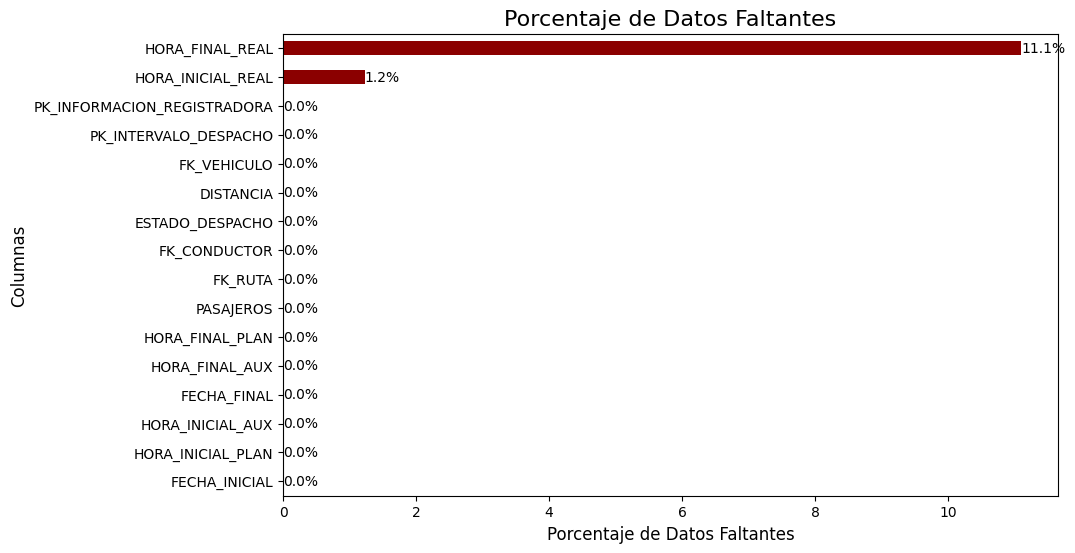

In [11]:
# Crear el gráfico de barras horizontal
plt.figure(figsize=(10, 6))
porcentaje_faltantes.sort_values().plot(kind='barh', color='darkred')

# Añadir título y etiquetas
plt.title('Porcentaje de Datos Faltantes', fontsize=16)
plt.xlabel('Porcentaje de Datos Faltantes', fontsize=12)
plt.ylabel('Columnas', fontsize=12)

# Mostrar el porcentaje en las barras
for i, v in enumerate(porcentaje_faltantes.sort_values()):
    plt.text(v , i, f'{v:.1f}%', color='black', va='center')

# Mostrar el gráfico
plt.show()

De acuerdo con la gráfica anterior, se puede observar que del total de 50884, despachos, el 10.8% no cuenta con una hora real final registrada, seguida del 1.2% de despachos que no registraron Hora inicial real.

# DESCRIPCIÓN DE LOS DATOS

In [12]:
df_cuantitativo = datos[['HORA_INICIAL_PLAN','HORA_INICIAL_REAL','HORA_INICIAL_AUX','HORA_FINAL_PLAN','HORA_FINAL_REAL',
                         'HORA_FINAL_AUX','PASAJEROS','DISTANCIA']]

In [13]:
df_cuantitativo.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
HORA_INICIAL_PLAN,55952.0,9.92,3.83,3.0,6.0,10.0,13.0,20.0
HORA_INICIAL_REAL,55265.0,9.96,3.80,4.0,7.0,10.0,13.0,19.0
HORA_INICIAL_AUX,55952.0,9.86,3.93,0.0,6.0,10.0,13.0,19.0
HORA_FINAL_PLAN,55952.0,12.37,3.86,5.0,9.0,12.0,16.0,22.0
HORA_FINAL_REAL,49744.0,11.84,3.75,5.0,9.0,12.0,15.0,21.0
HORA_FINAL_AUX,55952.0,13.07,4.99,4.0,9.0,12.0,16.0,23.0
PASAJEROS,55952.0,46.16,16.31,1.0,36.0,45.0,55.0,868.0
DISTANCIA,55952.0,37019.56,5634.92,0.0,35900.0,36700.0,38600.0,91300.0


De la descripción de datos numéricos se puede observar que:
- Entre las hora inicial planeada y real: se observan que los promedios son símilares tomando valores de 9,9 y 9.87 queriendo decir que en promedio los despachos salen a esa hora.

- Entre Hora final planeada y real: Se observa que hay diferencias aparentes entre sus medias la media de horas finales planeadas es a las 12:36 y para las horas planeadas es de 11.86. Esto sugiere inicialmente, que hay un retraso promedio en los retrasos al comparar estas dos medias. Sus desviaciones parecen similares siendo la hora final real un poco más variable.

- Observando los mínimos y máximos de Todas las variables temporales, se observan que están dentro de los rango establecidos posibles para un rango horario desde las 0 a las 24 horas.

## Sobre Datos FK:

Estos datos no tienen una interpretación numérica ya que es un código de una ruta establecida. Estas corresponden al trayecto que debe recorrer el bus despachado. Se observa que hay un total de 6 rutas registrados en los datos.

## Sobre Pasajeros:

Se observa que en promedio los despachos recogen a 46 pasajeros con una desviación de más o menos 16 pasajeros, en un rango entre 1 a 868 pasajeros. Acá tendrémos que observar el máximo tomado puesto que los buses tienen un cupo máximo aproximado de 40 pasajeros incluidos aquellos que viajan de pie, en un mismo despacho.

## Sobre Distancia (mts):

Se observa que en promedio las distancia recorrido en los despachos es de  36882.71 con una desviación estándar de más o meno 5595.14 metros con valores que van desde 0mts hasta 91300.0 mts. Estos datos se deben contrastar con los parámetros esperados, observando aquellos que obtuvieron un recorrido de 0mts.


In [14]:
df_cualitativo = datos[['FECHA_INICIAL','FECHA_FINAL','FK_RUTA','ESTADO_DESPACHO']]

In [15]:
# Grafica de boxplot
(df_cualitativo['FK_RUTA'].value_counts(normalize = True) * 100).round(2)

FK_RUTA
3    48.87
1    47.92
6     1.79
5     1.42
Name: proportion, dtype: float64

En cuanto al tipo de rutas se puede observar que hay un total de 4 rutas diferentes. La ruta 3 y la ruta 1 son las que más despachos registraron en el data set, con una participación del 48,8% para la ruta 3 y un 48,1% para la ruta 1. La ruta 6 y 5 tienen mucho menos participación con un porcentaje de 1,7% y 1,4% del total de despachos.

# DATOS ATIPICOS

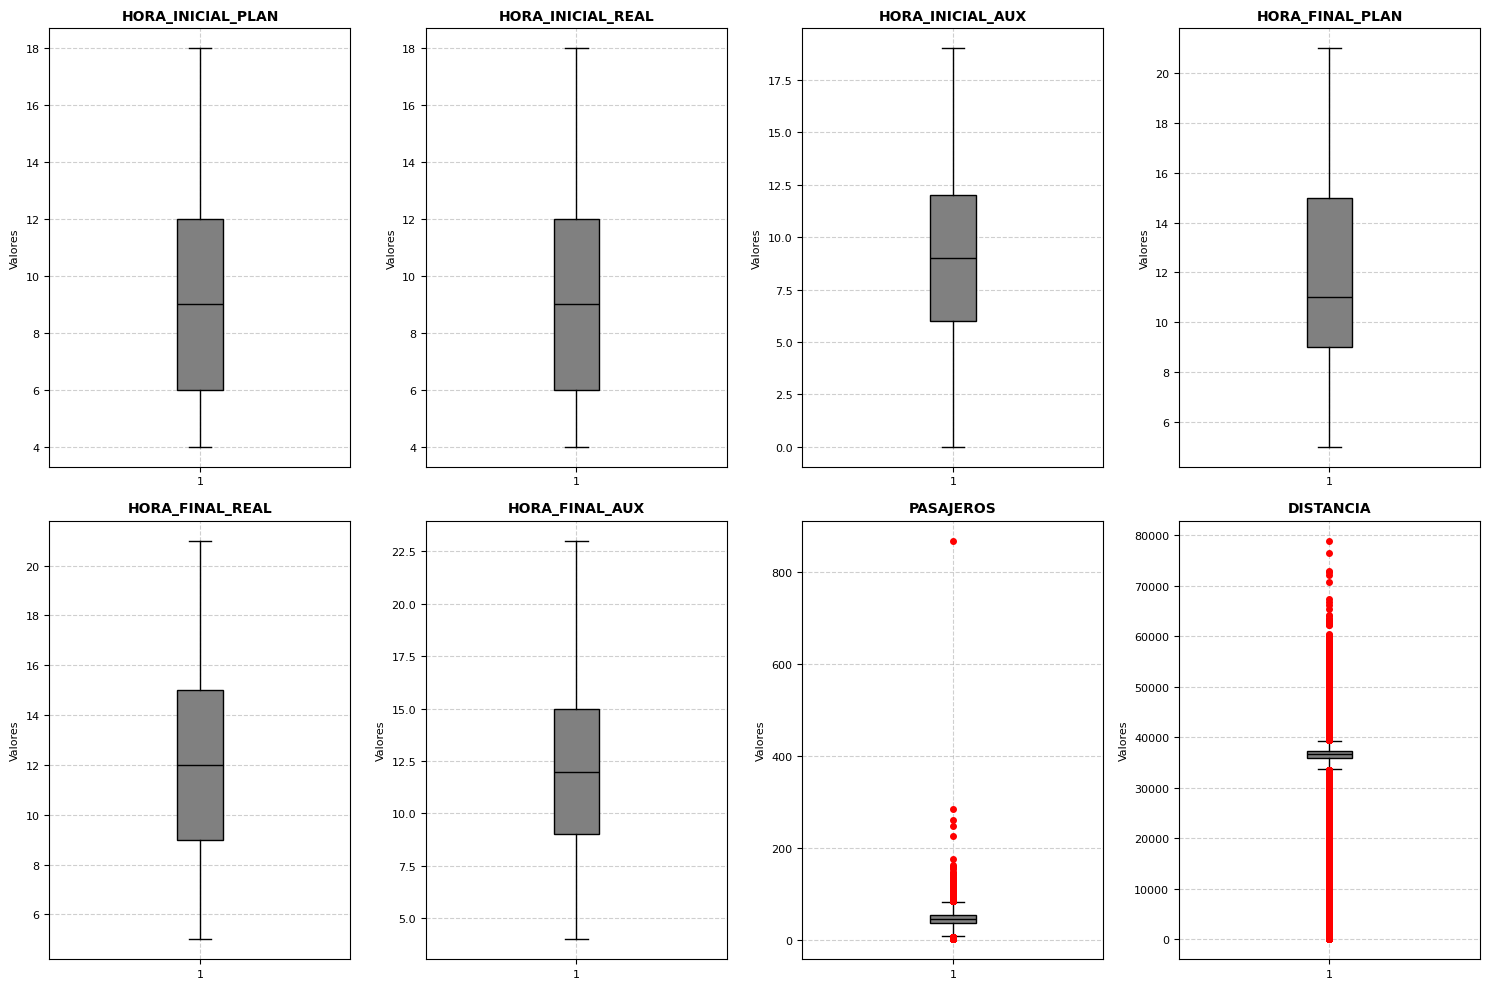

In [16]:
df_cuantitativo = df_cuantitativo.dropna()

# Configurar el marco de subplots
fig, axes = plt.subplots(2, 4, figsize=(15, 10))  # 2 filas x 4 columnas
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # Espaciado entre subplots

# Aplanar el array de ejes para iteración fácil
axes = axes.flat

# Generar un boxplot para cada variable
for i, columna in enumerate(df_cuantitativo.columns):
    # Crear boxplot con parámetros personalizados
    bp = axes[i].boxplot(df_cuantitativo[columna],
                        vert=True,  # Vertical
                        patch_artist=True,  # Para rellenar las cajas
                        flierprops=dict(marker='o',  # Outliers en círculos
                                       markerfacecolor='red',  # Color rojo
                                       markeredgecolor='red',
                                       markersize=4),
                        boxprops=dict(facecolor='gray',  # Color gris
                                     color='black'),  # Borde negro
                        medianprops=dict(color='black'))  # Línea mediana negra

    # Configuraciones adicionales
    axes[i].set_title(columna, fontsize=10, fontweight='bold')
    axes[i].set_ylabel('Valores', fontsize=8)
    axes[i].tick_params(axis='both', labelsize=8)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Eliminar ejes vacíos si hay menos variables que subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

# Ajustar layout y mostrar
plt.tight_layout()
plt.show()

1. HORA_INICIAL_PLAN
La distribución de las horas planificadas de inicio muestra una mediana centrada, con un rango intercuartílico estrecho, lo que sugiere una programación generalmente uniforme. Sin embargo, outliers en los extremos inferiores y superiores indican horarios de inicio excepcionalmente tempranos (antes del bigote inferior) o tardíos (después del bigote superior).

2. HORA_INICIAL_REAL
Comparado con la planificación, este gráfico presenta una dispersión más amplia, con una mediana ligeramente desplazada hacia valores mayores, lo que sugiere retrasos frecuentes. Los outliers superiores (horas muy tardías) son numerosos y se concentran en franjas extremas, indicando despachos que iniciaron con demoras críticas, posiblemente por fallas mecánicas, congestión de rutas o imprevistos logísticos. Los outliers inferiores (horas prematuras) son escasos pero relevantes, apuntando a despachos adelantados no documentados.

3. HORA_INICIAL_AUX
Las horas registradas por sistemas auxiliares muestran una distribución bimodal (dos picos en la caja), lo que sugiere inconsistencias entre dispositivos de registro. Los outliers dispersos en ambos extremos podrían deberse a errores de sincronización horaria entre sistemas, registros manuales incorrectos o eventos excepcionales (ej: cambios de huso horario no actualizados).

4. HORA_FINAL_PLAN
La planificación de finalización tiene un IQR compacto, con una mediana alineada a jornadas laborales típicas. No obstante, los outliers superiores (horas muy tardías) revelan planes que exceden significativamente la duración esperada, posiblemente por rutas extensas asignadas sin ajustar los tiempos. Estos casos requieren revisión para evitar sobrecargas en conductores o vehículos.

5. HORA_FINAL_REAL
Este gráfico contrasta marcadamente con la planificación: la mediana está desplazada hacia arriba, y el IQR es más amplio, evidenciando que las finalizaciones reales suelen ser más tardías que lo previsto. Los outliers superiores (horas extremadamente tardías) son frecuentes y podrían vincularse a factores como condiciones climáticas adversas, accidentes o fallas en vehículos. La presencia de outliers inferiores (finalizaciones abruptas) sugiere interrupciones no planificadas, como cancelaciones de viajes.

6. HORA_FINAL_AUX
Similar a HORA_INICIAL_AUX, este gráfico muestra inconsistencias técnicas: outliers alejados del bigote superior indican registros de finalización con horas incongruentes.

7. DISTANCIA
La distancia recorrida tiene una distribución sesgada a la derecha (cola larga hacia valores altos), con una mediana baja pero outliers extremos en el rango superior. Estos valores atípicos representan viajes con distancias anormalmente largas, que podrían deberse a desvíos no autorizados, errores en la asignación de rutas o incluso fraudes (ej: vehículos tomando rutas innecesarias). Los outliers inferiores (distancias cercanas a cero) son mínimos pero alertan sobre viajes cancelados o registros erróneos.

8. PASAJEROS
La distribución de pasajeros es altamente variable, con una mediana baja y un IQR amplio, reflejando la fluctuación natural de la demanda. Sin embargo, los outliers superiores (valores muy altos) indican viajes con sobrecupo, lo que podría violar normas de seguridad. Por otro lado, los outliers inferiores (viajes vacíos) sugieren despachos innecesarios o fallas en la coordinación entre la oferta y la demanda.

# Filtrado de datos
Se procede a filtrar los datos atipicos referentes al conteo de los pasajeros.